In [53]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import gzip
import keras
import numpy as np

In [54]:
# Dictionary displaying clothing categories corresponding to the following label categories
labels_map = {
  0: 'T-Shirt',
  1: 'Trouser',
  2: 'Pullover',
  3: 'Dress',
  4: 'Coat',
  5: 'Sandal',
  6: 'Shirt',
  7: 'Sneaker',
  8: 'Bag',
  9: 'Ankle Boot',
}

In [55]:
#Load the Fashion MNIST dataset from the Keras API
(training_images, training_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Explicitly cast labels to int64
training_labels = training_labels.astype(np.int64)
test_labels = test_labels.astype(np.int64)

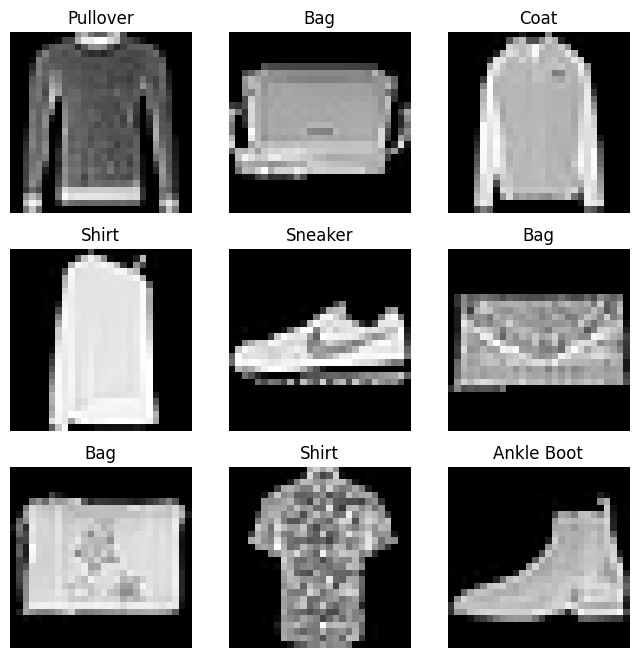

In [56]:
# Display sample images and their corresponding labels from the training data
import random
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols = 3
rows = 3

for i in range(1, cols * rows + 1):
  sample_idx = random.randint(0, len(training_images))
  image = training_images[sample_idx]
  label = training_labels[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(image.squeeze(), cmap='gray')
plt.show()


In [57]:
# Convert the pixel values to floating point numbers between 0 and 1
train_dataset = tf.data.Dataset.from_tensor_slices((training_images, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [58]:
train_dataset = train_dataset.map(lambda image, label: (float(image) / 255.0, label))
test_dataset = test_dataset.map(lambda image, label: (float(image) / 255.0, label))

In [59]:
train_dataset.as_numpy_iterator().next()[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [60]:
batch_size = 64
train_dataset = train_dataset.batch(batch_size).shuffle(500)
test_dataset = test_dataset.batch(batch_size).shuffle(500)

In [61]:
len(train_dataset.as_numpy_iterator().next()[0])

64

In [62]:
@keras.saving.register_keras_serializable()
class NeuralNetwork(tf.keras.Model):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.sequence = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(20, activation='relu'),
      tf.keras.layers.Dense(10)
    ])

  def call(self, x: tf.Tensor) -> tf.Tensor:
    y_prime = self.sequence(x)
    return y_prime

  @classmethod
  def from_config(cls, config):
    # The config dictionary will contain arguments saved by get_config().
    # Since our __init__ doesn't take any arguments, we can ignore the config
    # and just create a new instance of the class.
    return cls()

In [63]:
model = NeuralNetwork()
model.build((1, 28, 28))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "neural_network_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ (None, 10)             │        15,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,910 (62.15 KB)

 Trainable params: 15,910 (62.15 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
learning_rate = 0.1
batch_size = 64

model = NeuralNetwork()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)

In [65]:
print("=== DATA TYPE CHECK ===")
print(f"Training images dtype: {training_images.dtype}")
print(f"Training labels dtype: {training_labels.dtype}")
print(f"Training images shape: {training_images.shape}")
print(f"Training labels shape: {training_labels.shape}")


=== DATA TYPE CHECK ===
Training images dtype: uint8
Training labels dtype: int64
Training images shape: (60000, 28, 28)
Training labels shape: (60000,)


In [66]:
# Custom training step that takes a batch of images and labels, calculates the loss, compute the gradients and updates the model's weights using the optimizer
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # Make predictions
        predictions = model(images, training=True)
        # Calculate the loss
        loss = loss_fn(labels, predictions)

    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [67]:
# Custom training loop that iterates over the train_dataset for 5 epochs, calling the custom training step for each batch.
@tf.function
def test_step(images, labels):
    # Make predictions
    predictions = model(images, training=False)
    # Calculate the loss
    loss = loss_fn(labels, predictions)
    return loss

epochs = 5

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    total_train_loss = 0.0
    num_train_batches = 0
    for images, labels in train_dataset:
        loss = train_step(images, labels)
        total_train_loss += loss
        num_train_batches += 1

    avg_train_loss = total_train_loss / num_train_batches
    print(f"  Training Loss: {avg_train_loss:.4f}")

    total_test_loss = 0.0
    num_test_batches = 0
    for images, labels in test_dataset:
        loss = test_step(images, labels)
        total_test_loss += loss
        num_test_batches += 1

    avg_test_loss = total_test_loss / num_test_batches
    print(f"  Test Loss: {avg_test_loss:.4f}")

print("\nTraining finished.")


Epoch 1/5
  Training Loss: 0.6349
  Test Loss: 0.6217

Epoch 2/5
  Training Loss: 0.4687
  Test Loss: 0.4791

Epoch 3/5
  Training Loss: 0.4312
  Test Loss: 0.4728

Epoch 4/5
  Training Loss: 0.4107
  Test Loss: 0.4368

Epoch 5/5
  Training Loss: 0.3955
  Test Loss: 0.4491

Training finished.


In [68]:
# A function that performs a forward pass on a batch of test data and calculates the number of correct predictions
@tf.function
def evaluate_step(images, labels):
  """Performs a forward pass and calculates correct predictions."""
  predictions = model(images, training=False)
  predicted_classes = tf.argmax(predictions, axis=1)
  correct_predictions = tf.equal(predicted_classes, labels)
  return tf.reduce_sum(tf.cast(correct_predictions, dtype=tf.int32))

In [69]:
# A custom evaluation loop that iterates over the test dataset, calling the custom evaluation step for each batch and accumulating the total number of correct predictions
total_correct_predictions = 0
total_test_samples = 0

for images, labels in test_dataset:
    correct_predictions_batch = evaluate_step(images, labels)
    total_correct_predictions += correct_predictions_batch.numpy()
    total_test_samples += len(labels.numpy())

In [70]:
# The total number of correct predictions divided by the total number of test samples to get the accuracy.
accuracy = total_correct_predictions / total_test_samples
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8427


In [71]:
import os

# Define the directory and filename to save the model with .keras extension
model_save_path = "./fashion_mnist_model.keras"

# Save the model using model.save() with the .keras extension
model.save(model_save_path)

print(f"Model saved to: {os.path.abspath(model_save_path)}")

Model saved to: /content/fashion_mnist_model.keras


In [72]:
# Load the saved model
loaded_model = tf.keras.models.load_model("./fashion_mnist_model.keras")

# Display the loaded model summary to confirm it's loaded correctly
loaded_model.summary()

Model: "neural_network_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 10)             │        15,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,912 (62.16 KB)

 Trainable params: 15,910 (62.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Now that the model is loaded, we can use it to make predictions. I'll take a sample image from the test dataset and use the loaded model to predict its class.

In [73]:
# Get a sample image and label from the test dataset
sample_image, sample_label = next(iter(test_dataset))

# Take the first image and label from the batch
single_image = sample_image[0]
single_label = sample_label[0]

# Add a batch dimension to the image before making a prediction
single_image = tf.expand_dims(single_image, axis=0)

# Make a prediction using the loaded model
predictions = loaded_model.predict(single_image)

# The predictions are logits, so apply softmax to get probabilities
probabilities = tf.nn.softmax(predictions[0])

# Get the predicted class with the highest probability
predicted_class = tf.argmax(probabilities).numpy()

# Get the actual label
actual_label = single_label.numpy()

print(f"Predicted class: {labels_map[predicted_class]}")
print(f"Actual label: {labels_map[actual_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted class: Sneaker
Actual label: Sneaker
